# Projeto - Eye Tracker

## Primeira sprint: Crop dos olhos

### Instalando bibliotecas

In [ ]:
!pip install face_alignment==1.3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for face-alignment: filename=face_alignment-1.3.5-py2.py3-none-any.whl size=28241 sha256=2417606fa820de7cb68e6e452c502f8ee9c07e677dc04f3b4f1cbc94d379e3e3
  Stored in directory: /root/.cache/pip/wheels/c9/ba/4d/2d368f55e5f929f9472da59e356fbdf1483f885de80a5bc620
Successfully built face-alignment


### Imports

In [ ]:
from __future__ import absolute_import, division, print_function

import argparse
import os

import numpy as np
from skimage import io
from tqdm import tqdm
import cv2

## Extract frames from a given video


In [ ]:
global arg_file

class ArgsFile:
  video_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/video/video.mp4'
  images_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/images'

arg_file = ArgsFile()

def main():
    os.makedirs(arg_file.images_path, exist_ok=True)
    reader = cv2.VideoCapture(arg_file.video_path)
    frame_num = 0
    while reader.isOpened():
      # print(frame_num)
      success, image = reader.read()
      if not success:
        print("Deu ruim")
        break
      cv2.imwrite(os.path.join(arg_file.images_path, '{:04d}.png'.format(frame_num)), image)
      frame_num += 1
        
    reader.release()

In [ ]:
main()

## Face align

In [ ]:
'''
Align faces to generate 68 landmarks and bounding boxes
'''

import argparse
import os

import face_alignment

global args_face

class ArgsFace:
  images_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/images'
  landmarks_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/landmarks'
  boxes_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/boxes'
  log_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/logs'

args_face = ArgsFace()

def main_face_align():
    os.makedirs(args_face.landmarks_path, exist_ok=True)
    os.makedirs(args_face.boxes_path, exist_ok=True)
    fan = face_alignment.FaceAlignment(
        face_alignment.LandmarksType._2D, flip_input=False)
    preds = fan.get_landmarks_from_directory(
        args_face.images_path, return_bboxes=True)
    for image_file, (landmark, _, box) in preds.items():
        if not box:
            os.makedirs(args_face.log_path, exist_ok=True)
            with open(os.path.join(args_face.log_path, 'log.txt'), 'a') as logger:
                logger.write(os.path.abspath(image_file) + '\n')
            continue
        landmark = np.array(landmark)[0]
        box = np.array(box)[0, :4]
        npy_file_name = os.path.splitext(
            os.path.basename(image_file))[0] + '.npy'
        image_landmark_path = os.path.join(args_face.landmarks_path, npy_file_name)
        image_box_path = os.path.join(args_face.boxes_path, npy_file_name)
        np.save(image_landmark_path, landmark)
        np.save(image_box_path, box)

In [ ]:
main_face_align()

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

0it [00:00, ?it/s]


## Funções para o crop do olho

In [ ]:
import cv2
import numpy as np
from skimage import io

In [ ]:
def crop_eye_image(landmarks, box, image_file, eye_width=60, eye_height=48, face_width=380, face_height=380):
    image = io.imread(image_file)
    if image_file.endswith('.png'):
        image = image[:, :, :3]
    box[0], box[2] = (box[0]+box[2]-face_width)//2, \
                     (box[0]+box[2]+face_width)//2
    box[1], box[3] = (box[1]+box[3]-face_height)//2, \
                     (box[1]+box[3]+face_height)//2
    face_color = image[int(box[1]):int(box[3]), int(box[0]):int(box[2]), :]

    eye_indices = np.array([36, 39, 42, 45])
    eye_landmarks = landmarks[eye_indices]
    eye_landmarks[:, 0] -= box[0]
    eye_landmarks[:, 1] -= box[1]
    margin_ratio = 1.0
    desired_ratio = float(eye_height) / float(eye_width) / 2.0

    try:
        # Get the width of the eye, and compute how big the margin should be according to the width
        lefteye_width = eye_landmarks[3][0] - eye_landmarks[2][0]
        righteye_width = eye_landmarks[1][0] - eye_landmarks[0][0]

        lefteye_center_x = eye_landmarks[2][0] + lefteye_width / 2
        righteye_center_x = eye_landmarks[0][0] + righteye_width / 2
        lefteye_center_y = (eye_landmarks[2][1] + eye_landmarks[3][1]) / 2.0
        righteye_center_y = (eye_landmarks[1][1] + eye_landmarks[0][1]) / 2.0

        aligned_face, rot_matrix = align_face_to_eyes(face_color, right_eye_center=(righteye_center_x, righteye_center_y),
                                                      left_eye_center=(lefteye_center_x, lefteye_center_y))

        # rotate the eye landmarks by same affine rotation to extract the correct landmarks
        ones = np.ones(shape=(len(eye_landmarks), 1))
        points_ones = np.hstack([eye_landmarks, ones])
        transformed_eye_landmarks = rot_matrix.dot(points_ones.T).T

        # recompute widths, margins and centers
        lefteye_width = transformed_eye_landmarks[3][0] - \
            transformed_eye_landmarks[2][0]
        righteye_width = transformed_eye_landmarks[1][0] - \
            transformed_eye_landmarks[0][0]
        lefteye_margin, righteye_margin = lefteye_width * \
            margin_ratio, righteye_width * margin_ratio
        lefteye_center_y = (
            transformed_eye_landmarks[2][1] + transformed_eye_landmarks[3][1]) / 2.0
        righteye_center_y = (
            transformed_eye_landmarks[1][1] + transformed_eye_landmarks[0][1]) / 2.0

        # Now compute the bounding boxes
        # The left / right x-coordinates are computed as the landmark position plus/minus the margin
        # The bottom / top y-coordinates are computed according to the desired ratio, as the width of the image is known
        left_bb = np.zeros(4, dtype=np.int)
        left_bb[0] = transformed_eye_landmarks[2][0] - lefteye_margin / 2.0
        left_bb[1] = lefteye_center_y - \
            (lefteye_width + lefteye_margin) * desired_ratio
        left_bb[2] = transformed_eye_landmarks[3][0] + lefteye_margin / 2.0
        left_bb[3] = lefteye_center_y + \
            (lefteye_width + lefteye_margin) * desired_ratio

        right_bb = np.zeros(4, dtype=np.int)
        right_bb[0] = transformed_eye_landmarks[0][0] - righteye_margin / 2.0
        right_bb[1] = righteye_center_y - \
            (righteye_width + righteye_margin) * desired_ratio
        right_bb[2] = transformed_eye_landmarks[1][0] + righteye_margin / 2.0
        right_bb[3] = righteye_center_y + \
            (righteye_width + righteye_margin) * desired_ratio

        # Extract the eye images from the aligned image
        left_eye_color = aligned_face[left_bb[1]
            :left_bb[3], left_bb[0]:left_bb[2], :]
        right_eye_color = aligned_face[right_bb[1]
            :right_bb[3], right_bb[0]:right_bb[2], :]

        # So far, we have only ensured that the ratio is correct. Now, resize it to the desired size.
        left_eye_color_resized = cv2.resize(
            left_eye_color, (eye_width, eye_height), interpolation=cv2.INTER_CUBIC)
        right_eye_color_resized = cv2.resize(
            right_eye_color, (eye_width, eye_height), interpolation=cv2.INTER_CUBIC)

        return left_eye_color_resized, right_eye_color_resized, left_bb, right_bb

    except ValueError:
        return None, None, None, None
    except TypeError:
        return None, None, None, None
    except cv2.error:
        return None, None, None, None

In [ ]:
def align_face_to_eyes(face_img, right_eye_center, left_eye_center, face_width=None, face_height=None):
    # modified from https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
    desired_left_eye = (0.35, 0.35)
    desired_face_width = face_width if face_width is not None else face_img.shape[1]
    desired_face_height = face_height if face_height is not None else face_img.shape[0]
    # compute the angle between the eye centroids
    d_y = right_eye_center[1] - left_eye_center[1]
    d_x = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(d_y, d_x)) - 180

    # compute the desired right eye x-coordinate based on the
    # desired x-coordinate of the left eye
    desired_right_eye_x = 1.0 - desired_left_eye[0]

    # determine the scale of the new resulting image by taking
    # the ratio of the distance between eyes in the *current*
    # image to the ratio of distance between eyes in the
    # *desired* image
    dist = np.sqrt((d_x ** 2) + (d_y ** 2))
    desired_dist = (desired_right_eye_x - desired_left_eye[0])
    desired_dist *= desired_face_width
    scale = desired_dist / dist

    # compute center (x, y)-coordinates (i.e., the median point)
    # between the two eyes in the input image
    eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                   (left_eye_center[1] + right_eye_center[1]) // 2)

    # grab the rotation matrix for rotating and scaling the face
    m = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # update the translation component of the matrix
    t_x = desired_face_width * 0.5
    t_y = desired_face_height * desired_left_eye[1]
    m[0, 2] += (t_x - eyes_center[0])
    m[1, 2] += (t_y - eyes_center[1])

    # apply the affine transformation
    (w, h) = (desired_face_width, desired_face_height)
    aligned_face = cv2.warpAffine(face_img, m, (w, h), flags=cv2.INTER_NEAREST)
    return aligned_face, m

## Eye Cropper

In [ ]:

import parser

global args

class Args:
  images_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/images'
  landmarks_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/landmarks'
  boxes_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/boxes'
  eye_width = 60
  eye_height = 48
  face_roi_width = 300
  face_roi_height = 300
  left_eye_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/left_eye'
  right_eye_path = '/content/drive/MyDrive/Insper/6_semestre/computer_vision/Eye_tracking/test/right_eye'

args = Args()

def main():

    # crop eyes
    print('\033[36mCropping eye images ...\033[0m')
    os.makedirs(args.left_eye_path, exist_ok=True)
    os.makedirs(args.right_eye_path, exist_ok=True)
    for box_file in tqdm(sorted(os.listdir(args.boxes_path))):
        box_path = os.path.join(args.boxes_path, box_file)
        landmarks_path = os.path.join(args.landmarks_path, box_file)
        box_file = os.path.splitext(box_file)[0] + '.png'
        image_path = os.path.join(args.images_path, box_file)
        left_eye_img, right_eye_img, _, _ = crop_eye_image(np.load(landmarks_path),
                                                           np.load(box_path),
                                                           image_path,
                                                           eye_width=args.eye_width,
                                                           eye_height=args.eye_height,
                                                           face_width=args.face_roi_width,
                                                           face_height=args.face_roi_height)
        if left_eye_img is None or right_eye_img is None:
            print(f'\033[35m[WARNING] Failed to crop eye image in {box_file}, \
            please lower the argument `--face-roi-width` or `--face-roi-height`\033[0m')
        else:
            io.imsave(os.path.join(args.left_eye_path, box_file), left_eye_img)
            io.imsave(os.path.join(
                args.right_eye_path, box_file), right_eye_img)

In [ ]:
main()

Cropping eye images ...


0it [00:00, ?it/s]


# Media pipe

In [4]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 1.4 MB/s 


In [5]:
from google.colab import files
uploaded = files.upload()

# from pathlib import Path

# uploaded = 'https://drive.google.com/drive/folders/1-CAD_fB7HjqcTl7iKDIj4VLJM3R5Np-Y?usp=sharing'

# import gdown
# gdown.download_folder(uploaded, quiet=True, remaining_ok = True)

Saving 0030.png to 0030.png


0030.png


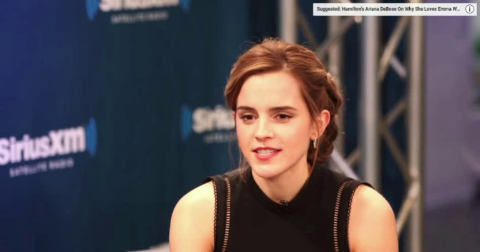

In [6]:
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}
# Preview the images.
for name, image in images.items():
  print(name)   
  resize_and_show(image)

In [7]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh

help(mp_face_mesh.FaceMesh)

Help on class FaceMesh in module mediapipe.python.solutions.face_mesh:

class FaceMesh(mediapipe.python.solution_base.SolutionBase)
 |  FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |  
 |  MediaPipe Face Mesh.
 |  
 |  MediaPipe Face Mesh processes an RGB image and returns the face landmarks on
 |  each detected face.
 |  
 |  Please refer to https://solutions.mediapipe.dev/face_mesh#python-solution-api
 |  for usage examples.
 |  
 |  Method resolution order:
 |      FaceMesh
 |      mediapipe.python.solution_base.SolutionBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, static_image_mode=False, max_num_faces=1, refine_landmarks=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |      Initializes a MediaPipe Face Mesh object.
 |      
 |      Args:
 |        static_image_mode: Whether to treat the input images as a batch of static
 |          and

In [8]:
# Load drawing_utils and drawing_styles
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [1]:
# Run MediaPipe Face Mesh.
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=2,
    min_detection_confidence=0.65) as face_mesh:
  for name, image in images.items():
    # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw face landmarks of each face.
    print(f'Face landmarks of {name}:')
    if not results.multi_face_landmarks:
      continue
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
      # mp_drawing.draw_landmarks(
      #     image=annotated_image,
      #     landmark_list=face_landmarks,
      #     connections=mp_face_mesh.FACEMESH_TESSELATION,
      #     landmark_drawing_spec=None,
      #     connection_drawing_spec=mp_drawing_styles
      #     .get_default_face_mesh_tesselation_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_CONTOURS,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_contours_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_iris_connections_style())
    resize_and_show(annotated_image)

NameError: ignored

# Referências

- https://github.com/1adrianb/face-alignment